In [39]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tf_agents
from tf_agents.bandits.environments import movielens_py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.bandits.environments import environment_utilities
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents import linear_thompson_sampling_agent as lin_ts_agent
from tf_agents.networks import q_network
from tf_agents.bandits.agents import neural_epsilon_greedy_agent as eps_greedy_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import driver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import random_tf_policy
import functools
import numpy as np
from matplotlib import pyplot as plt

In [40]:
BATCH_SIZE = 8
TRAINING_LOOPS = 500
STEPS_PER_LOOP = 1
RANK_K = 20
NUM_ACTIONS = 20
DATA_PATH = 'u.data'

In [41]:
env = movielens_py_environment.MovieLensPyEnvironment(
        DATA_PATH,
        RANK_K,
        BATCH_SIZE,
        num_movies=NUM_ACTIONS,
        csv_delimiter='\t')
environment = tf_py_environment.TFPyEnvironment(env)

In [42]:
optimal_reward_fn = functools.partial(
      environment_utilities.compute_optimal_reward_with_movielens_environment,
      environment=environment)


optimal_action_fn = functools.partial(
      environment_utilities.compute_optimal_action_with_movielens_environment,
      environment=environment)

In [43]:
AGENT_ALPHA = 10.0
linucb = lin_ucb_agent.LinearUCBAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        tikhonov_weight=0.001,
        alpha=AGENT_ALPHA,
        dtype=tf.float32,
        accepts_per_arm_features=False)

In [44]:
lints = lin_ts_agent.LinearThompsonSamplingAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        dtype=tf.float32,
        accepts_per_arm_features=False)

In [45]:
EPSILON = 0.05
LAYERS = (10, 10, 10)
LR = 0.005

network = q_network.QNetwork(
          input_tensor_spec=environment.time_step_spec().observation,
          action_spec=environment.action_spec(),
          fc_layer_params=LAYERS)

neureps = eps_greedy_agent.NeuralEpsilonGreedyAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        reward_network=network,
        optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
        epsilon=EPSILON,
        emit_policy_info='predicted_rewards_mean',
        info_fields_to_inherit_from_greedy=['predicted_rewards_mean'])

In [46]:
regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)
suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(optimal_action_fn)

In [47]:
def train(agent):

  if agent == 'LinUCB':
    agent = linucb
  elif agent == 'LinTS':
    agent = lints
  elif agent == 'NeurEps':
    agent = neureps


  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=BATCH_SIZE,
    max_length=STEPS_PER_LOOP)

  observers = [replay_buffer.add_batch, regret_metric]

  driver = dynamic_step_driver.DynamicStepDriver(
      env=environment,
      policy=agent.collect_policy,
      num_steps=STEPS_PER_LOOP * BATCH_SIZE,
      observers=observers)

  regret_values = []

  for _ in range(TRAINING_LOOPS):
    driver.run()
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    regret_values.append(regret_metric.result())

  return regret_values, agent

Text(0, 0.5, 'Average Regret')

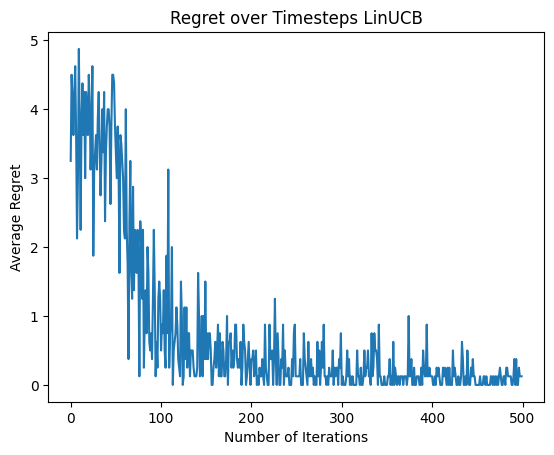

In [48]:
regret_values_linucb, linucb_agent = train('LinUCB')
plt.plot(regret_values_linucb)
plt.title('Regret over Timesteps LinUCB')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Regret')

In [49]:
sum(regret_values_linucb)

<tf.Tensor: shape=(), dtype=float32, numpy=384.125>

Text(0, 0.5, 'Average Regret')

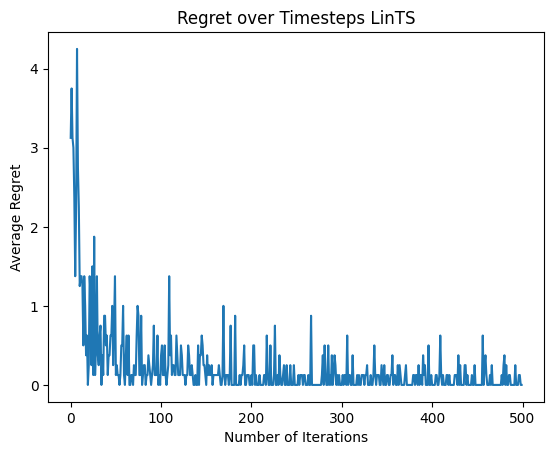

In [50]:
regret_values_lints, lints_agent = train('LinTS')
plt.plot(regret_values_lints)
plt.title('Regret over Timesteps LinTS')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Regret')

In [51]:
sum(regret_values_lints)

<tf.Tensor: shape=(), dtype=float32, numpy=116.375>

Text(0, 0.5, 'Average Regret')

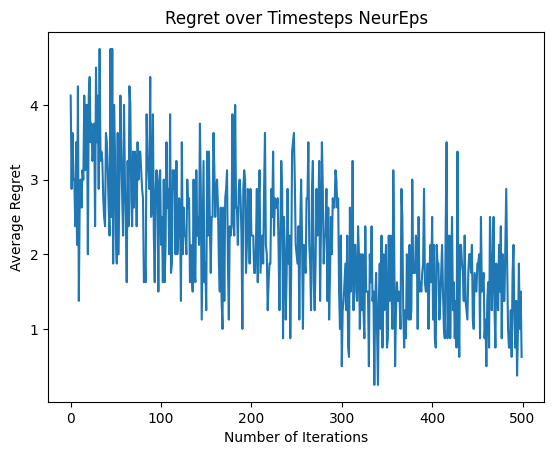

In [52]:
regret_values_neureps, neureps_agent = train('NeurEps')
plt.plot(regret_values_neureps)
plt.title('Regret over Timesteps NeurEps')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Regret')

In [53]:
sum(regret_values_neureps)

<tf.Tensor: shape=(), dtype=float32, numpy=1094.375>

In [54]:
def recommend_movies(agent, observation):
    time_step = tf_agents.trajectories.time_step.TimeStep(
        step_type=tf.constant([[2]], dtype=tf.int32),
        reward=tf.constant([[0.0]], dtype=tf.float32),
        discount=tf.constant([[1.0]], dtype=tf.float32),
        observation=observation)
    
    action_step = agent.policy.action(time_step)
    return action_step.action.numpy()[0]

In [55]:
observation = np.array([1, 25, 35, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1])
observation = np.expand_dims(observation, axis=0)
recommend_movies(lints_agent, observation=observation)

13